In [ ]:
import re
import string
import numpy as np
import pandas as pd 
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
from tqdm import tqdm as tq

import torch
import torch.nn as nn

In [ ]:
train_data = pd.read_csv("/content/train.csv", encoding="utf-8").drop("id", axis=1)[["tweet", "label"]]
train_data.head()

,tweet,label
0,@user when a father is dysfunctional and is s...,0
1,@user @user thanks for #lyft credit i can't us...,0
2,bihday your majesty,0
3,#model i love u take with u all the time in ...,0
4,factsguide: society now #motivation,0


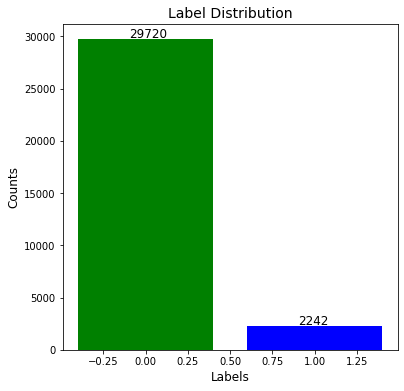

In [ ]:
labels = train_data["label"].value_counts().keys()
counts = train_data["label"].value_counts().values

plt.figure(figsize = (6, 6))
axes = plt.bar(x = labels, height = counts, color = ["green", "blue"])
plt.title("Label Distribution", fontdict={"fontsize": 14})
plt.xlabel("Labels", fontdict={"fontsize": 12})
plt.ylabel("Counts", fontdict={"fontsize": 12})
for i, ax in enumerate(axes.patches):
  plt.text(ax.get_x() + 0.3, ax.get_height() + 200, str(counts[i]), fontdict= {'fontsize':12})
plt.show()

In [ ]:
def clean_values(value):
  """
  Use this Function to clean the dataset tweet column 
  Use data["tweet"].map(this_fxn) to clean the column
  Use of this function is limited to some datasets only
  """

  # Strip the tweet text to remove any spaces at the beginning and end
  value = value.strip()

  # Lower case the value
  value = value.lower()

  # Remove Punctuation using translate() and maketans()
  ## The str.maketrans maps the puntutation in ascii character to empy space
  ## and translate() maps this dictionary to the text
  value = value.translate(str.maketrans("" , "", string.punctuation.replace("@", "")))

  # Custom removal of all occurances of @user keyword 
  value = value.replace("@user", "")

  # Remove html
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  value = url_pattern.sub("", value)

  # Remove emojis by check if the string is isalpha (very bad)
  return_text = ""
  for i in value:
    if (i.isalpha()) or (i == " "):
      return_text += i

  # Remove ð 
  return_text = return_text.replace("ð", "")
  return_text = return_text.replace("â", "")

  return_text = return_text.split()
  return_text = " ".join(return_text)
      
  # Return the value
  return return_text

In [ ]:
test = train_data.copy()
test["tweet"] = test["tweet"].map(clean_values)
test.head()

,tweet,label
0,when a father is dysfunctional and is so selfi...,0
1,thanks for lyft credit i cant use cause they d...,0
2,bihday your majesty,0
3,model i love u take with u all the time in ur,0
4,factsguide society now motivation,0


In [ ]:
empty_cells = test[test["tweet"].astype(str) == ""].index
test = test.drop(empty_cells, axis = 0).reset_index(drop=True)

#Tokenizing and Other Shit

In [ ]:
# calculate the lenght of the largest tweet to pad the rest of the tweets 
max_size = 0
for i in test["tweet"]:
  size_tweet = len(i.split())
  if size_tweet > max_size:
    max_size = size_tweet

print("Size of the longest tweet in the dataset is : %d" % (max_size))
max_length = max_size

Size of the longest tweet in the dataset is : 33


In [ ]:
def fetch_tokenizer_functions(tokenize_data):
  """
  Makes the counter and return the tokenizer word_to_idx and idx_to_word
  """
  vocab_str = ""
  for i in tqdm(tokenize_data):
    vocab_str = vocab_str + " " + i

  vocab_str = vocab_str.strip()
  #count_items = Counter(list(filter(lambda a: a != "", vocab_str.split())))
  count_items = Counter(vocab_str.split())

  word_to_idx = {word : idx for idx, (word, c) in enumerate(count_items.items(), 1)}
  idx_to_word = {idx : word for word, idx in word_to_idx.items()}

  return word_to_idx, idx_to_word


word_to_idx, idx_to_word = fetch_tokenizer_functions(test["tweet"])

In [ ]:
def tokenize_data_with_padding(input_data, word_to_idx, max_length):
  """
  This function converts the given input data into
  the tokenized format and 0 padded with the max_length 
  values
  padding_type is "pre"
  """
  list_return = []
  for text in tqdm(input_data):

    # Get some starter values
    text_max = np.zeros(shape=(max_length, ), dtype=np.int32)
    text_split = text.split()
    text_len = len(text_split)

    # Perform padding and tokenizing
    text_max[-text_len:] = [word_to_idx[word] for word in text_split]
    list_return.append(text_max)

  return np.array(list_return)


temp_tok = tokenize_data_with_padding(test["tweet"], word_to_idx, max_length)

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print("Using %s" % (str(device).upper()))

Using CUDA


#Modelling the Model

In [ ]:
class SADataset:
  def __init__(self, text_data, labels, is_train=True):
    self.text_data = text_data
    self.labels = labels
    self.is_train = is_train

  def __getitem__(self, index):
    if self.is_train:
      return {
          "x" : torch.from_numpy(np.array(self.text_data[index, :])).long(),
          "y" : torch.from_numpy(np.array(self.labels[index])).float()
      }

    else:
      return {
          "x" : torch.from_numpy(self.text_data[index, :]),
      }
  
  def __len__(self):
    return self.text_data.shape[0]


In [ ]:
class SAModel(nn.Module):
  def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
    super(SAModel, self).__init__()
    self.output_size = output_size
    self.n_layers = n_layers
    self.hidden_dim = hidden_dim

    # Rnn Layers
    self.embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                        dropout=drop_prob, batch_first=True, bidirectional=True)
    
    # Dropout and Linear Layer
    self.dropout = nn.Dropout(p = 0.5)
    self.linear = nn.Linear(in_features=2 * hidden_dim, out_features=output_size)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    embed = self.embedding_layer(x)
    reshaped = torch.reshape(embed, (-1, embed.shape[1], embed.shape[2]))
    lstm_out, hidden = self.lstm(reshaped)

    # Padding the lstm_out to the fully-connected layers 
    out = self.dropout(lstm_out)
    out = self.linear(out)
    out = self.sigmoid(out)[:, -1]
    return out

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
fold_type = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

for fold, (train_idx, val_idx) in enumerate(fold_type.split(X=temp_tok, y=test["label"]), 1):
  print('*-' * 10 + ' Training started for fold : %s ' % (fold) + '-*' * 10)
  print("Training on %d text and validating on %d text" % (len(train_idx), len(val_idx)))

  # Create the dataset and dataLoaders
  train_text = temp_tok[train_idx, :]
  train_labels = test["label"].iloc[train_idx].values

  val_text = temp_tok[val_idx, :]
  val_labels = test["label"].iloc[val_idx].values

  # Create the dataLoader and the dataset objects
  train_dataset = SADataset(text_data=train_text, labels=train_labels, is_train=True)
  val_dataset = SADataset(text_data=val_text, labels=val_labels, is_train=True)

  train_dataLoader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True,
                                                 num_workers=4, drop_last=False)
  
  val_dataLoader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=64, shuffle=False,
                                                 num_workers=4, drop_last=False)
  
  # List the parameters and the valuess
  vocab_size = len(word_to_idx) + 1
  output_size = 1
  embedding_dim = 256
  hidden_dim = 256
  n_layers = 2
  EPOCHS = 5
  
  # Load the model to the GPU/CPU
  model_fold = SAModel(vocab_size=vocab_size, output_size=output_size, 
                       embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                       n_layers=n_layers)
  model_fold.to(device)

  # Define the callbacks, loss and optimizer functions
  optimizer = torch.optim.Adam(model_fold.parameters(), lr = 0.0001)
  loss_fxn = nn.BCELoss()

  for epoch in range(EPOCHS):

    # Initialize the model and some other functions
    model_fold.train()
    correct_preds = 0
    losses = AverageMeter()
    progress_bar = tqdm(enumerate(train_dataLoader),
                        total=len(train_dataLoader))

    for i, data in progress_bar:
      # Load the data to the GPU
      x = data["x"].to(device)
      y = data["y"].to(device)

      batch_size_epoch = x.shape[0]

      # Pass the data through the model
      output = model_fold(x)
      loss = loss_fxn(output, y.unsqueeze(1))

      # Optimizer the network 
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      losses.update(loss.item(), batch_size_epoch)

      # Round the sigmoid activation to get the label
      output_rounded = output.round().cpu()
      correct_preds += (y.unsqueeze(1).cpu() == output_rounded).sum().item()

      # Set the tqdm description
      desc_step = 'epoch: %d loss: %.3f' % (epoch + 1, losses.avg)
      progress_bar.set_description(desc_step)

    # Get the accuracy after each opoch
    accuracy_train = (correct_preds / train_text.shape[0]) * 100

    # Put the model in eval() mode to freeze the layers and make val preictions
    model_fold.eval()

    val_preds = torch.zeros((val_text.shape[0], 1), dtype = torch.float32, device = device)
    with torch.no_grad():
      losses_val = AverageMeter()
      for batch_no, data in enumerate(val_dataLoader):
        # Load the data to GPU/CPU
        val_x = data["x"].to(device)
        val_y = data["y"].to(device)
        
        batch_size_epoch = val_x.shape[0]

        # Get the predictions
        output_val = model_fold(val_x)
        loss_val = loss_fxn(output_val, val_y.unsqueeze(1))
        losses_val.update(loss_val.item(), batch_size_epoch)

        # Append the ouputs to the val_preds
        val_preds[batch_no * val_dataLoader.batch_size : batch_no * val_dataLoader.batch_size + val_x.shape[0]] = output_val.round().cpu()

    # Calculate the validation accuracy here 
    val_acc = accuracy_score(val_labels, val_preds.cpu()) * 100
    print("EPOCH : %d | T_ACC : %.3f | T_LOSS : %.4f | V_ACC : %.3f | V_LOSS : %.4f" % (epoch, accuracy_train,
                                                                                        losses.avg, val_acc,
                                                                                        losses_val.avg))
    print("\n")
  print("\n")

*-*-*-*-*-*-*-*-*-*- Training started for fold : 1 -*-*-*-*-*-*-*-*-*-*
Training on 25568 text and validating on 6392 text



EPOCH : 0 | T_ACC : 92.056 | T_LOSS : 0.2699 | V_ACC : 93.789 | V_LOSS : 0.1926





EPOCH : 1 | T_ACC : 94.294 | T_LOSS : 0.1678 | V_ACC : 94.603 | V_LOSS : 0.1639





EPOCH : 2 | T_ACC : 95.420 | T_LOSS : 0.1298 | V_ACC : 94.853 | V_LOSS : 0.1496





EPOCH : 3 | T_ACC : 96.715 | T_LOSS : 0.0957 | V_ACC : 94.947 | V_LOSS : 0.1473





EPOCH : 4 | T_ACC : 97.677 | T_LOSS : 0.0695 | V_ACC : 95.479 | V_LOSS : 0.1549




*-*-*-*-*-*-*-*-*-*- Training started for fold : 2 -*-*-*-*-*-*-*-*-*-*
Training on 25568 text and validating on 6392 text



EPOCH : 0 | T_ACC : 92.252 | T_LOSS : 0.2766 | V_ACC : 93.257 | V_LOSS : 0.2082





EPOCH : 1 | T_ACC : 94.325 | T_LOSS : 0.1731 | V_ACC : 94.227 | V_LOSS : 0.1749





EPOCH : 2 | T_ACC : 95.447 | T_LOSS : 0.1330 | V_ACC : 95.009 | V_LOSS : 0.1583





EPOCH : 3 | T_ACC : 96.793 | T_LOSS : 0.0969 | V_ACC : 95.307 | V_LOSS : 0.1538





EPOCH : 4 | T_ACC : 97.755 | T_LOSS : 0.0699 | V_ACC : 95.135 | V_LOSS : 0.1663




*-*-*-*-*-*-*-*-*-*- Training started for fold : 3 -*-*-*-*-*-*-*-*-*-*
Training on 25568 text and validating on 6392 text



EPOCH : 0 | T_ACC : 92.229 | T_LOSS : 0.2729 | V_ACC : 93.648 | V_LOSS : 0.2068





EPOCH : 1 | T_ACC : 94.446 | T_LOSS : 0.1666 | V_ACC : 94.196 | V_LOSS : 0.1667





EPOCH : 2 | T_ACC : 95.721 | T_LOSS : 0.1276 | V_ACC : 94.556 | V_LOSS : 0.1621





EPOCH : 3 | T_ACC : 96.852 | T_LOSS : 0.0940 | V_ACC : 95.088 | V_LOSS : 0.1625





EPOCH : 4 | T_ACC : 97.919 | T_LOSS : 0.0665 | V_ACC : 94.712 | V_LOSS : 0.1576




*-*-*-*-*-*-*-*-*-*- Training started for fold : 4 -*-*-*-*-*-*-*-*-*-*
Training on 25568 text and validating on 6392 text



EPOCH : 0 | T_ACC : 92.854 | T_LOSS : 0.2695 | V_ACC : 93.946 | V_LOSS : 0.2024





EPOCH : 1 | T_ACC : 94.266 | T_LOSS : 0.1693 | V_ACC : 94.352 | V_LOSS : 0.1735





EPOCH : 2 | T_ACC : 95.592 | T_LOSS : 0.1286 | V_ACC : 94.806 | V_LOSS : 0.1570





EPOCH : 3 | T_ACC : 96.734 | T_LOSS : 0.0960 | V_ACC : 95.072 | V_LOSS : 0.1595





EPOCH : 4 | T_ACC : 97.884 | T_LOSS : 0.0657 | V_ACC : 95.494 | V_LOSS : 0.1633




*-*-*-*-*-*-*-*-*-*- Training started for fold : 5 -*-*-*-*-*-*-*-*-*-*
Training on 25568 text and validating on 6392 text



EPOCH : 0 | T_ACC : 91.974 | T_LOSS : 0.2774 | V_ACC : 93.601 | V_LOSS : 0.1970





EPOCH : 1 | T_ACC : 94.071 | T_LOSS : 0.1739 | V_ACC : 94.415 | V_LOSS : 0.1660





EPOCH : 2 | T_ACC : 95.326 | T_LOSS : 0.1327 | V_ACC : 94.759 | V_LOSS : 0.1570





EPOCH : 3 | T_ACC : 96.703 | T_LOSS : 0.0980 | V_ACC : 95.041 | V_LOSS : 0.1529





EPOCH : 4 | T_ACC : 97.794 | T_LOSS : 0.0695 | V_ACC : 95.432 | V_LOSS : 0.1626




